1)İş Problemi

2)Veriyi Anlamak

3)Veriyi Hazırlamak

4)Modelleme

5)Değerlendirme

1)Veriyi Anlamak

In [59]:
#Veriyi okuma ve işleme için kütüphaneler
import numpy as np
import pandas as pd
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt

#Model değerlendirme ve veriyi scale etmek için kütüphaneler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#Model için kütüphaneler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,SimpleRNN,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

#Warningleri kapatmak için
import warnings
warnings.filterwarnings('ignore')

#Tensorflow warning engelleme
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [60]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [61]:
dir_path= '/content/drive/MyDrive/international-airline-passengers.csv'
print(dir_path)

/content/drive/MyDrive/international-airline-passengers.csv


In [62]:
df=pd.read_csv(dir_path)
df.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [63]:
df.columns

Index(['Month', 'International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'], dtype='object')

In [64]:
df.columns=['Month','Passengers']
print(df.columns)

Index(['Month', 'Passengers'], dtype='object')


In [65]:
df.tail()

,Month,Passengers
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0
144,International airline passengers: monthly tota...,NaN


In [66]:
df.shape

(145, 2)

In [67]:
df.dtypes

Month          object
Passengers    float64
dtype: object

In [68]:
df.isnull().sum()

Month         0
Passengers    1
dtype: int64

In [69]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


2)Veriyi Hazırlamak

In [70]:
df=df[0:144] #son satırı sildik bozuk veri var diye

In [71]:
df['Month'] = pd.to_datetime(df['Month']) #tarih object idi datetime cinsine çevirdik

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.4 KB


In [73]:
print("Minimum Tarih: ",df["Month"].min())
print("Maksimum Tarih: ",df["Month"].max())

Minimum Tarih:  1949-01-01 00:00:00
Maksimum Tarih:  1960-12-01 00:00:00


In [74]:
df.index=df["Month"] #indexi 1,2,3,4 ... değilde tarihleri yapcaz

In [75]:
df.head()

,Month,Passengers
Month,,
1949-01-01,1949-01-01,112.0
1949-02-01,1949-02-01,118.0
1949-03-01,1949-03-01,132.0
1949-04-01,1949-04-01,129.0
1949-05-01,1949-05-01,121.0


In [76]:
df.drop("Month", axis=1, inplace=True) #ay kolonunu sildik,axis=1 kolon için 0 sütun,inplace=True kalıcı silme için

In [77]:
df.head()

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [78]:
result_df=df.copy() #kopyaladık

<Axes: title={'center': 'Monthly airline passengers'}, xlabel='Month'>

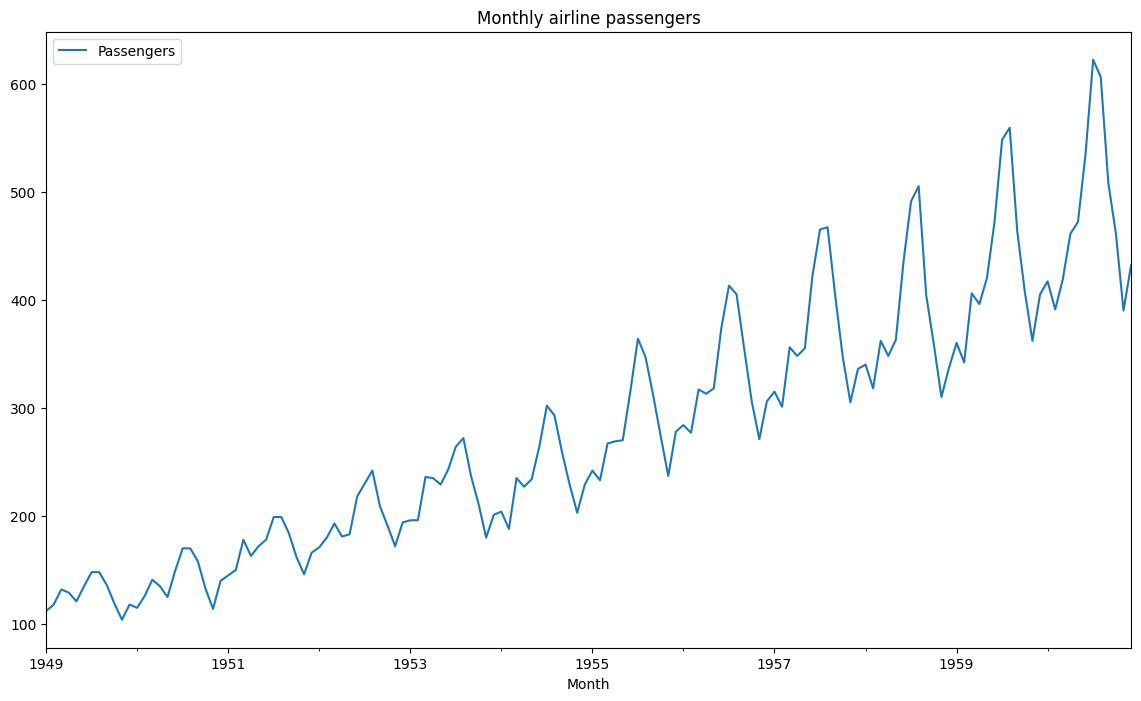

In [79]:
df.plot(figsize=(14,8),title='Monthly airline passengers')

**Veri Pandas Dataframe formatında,modelleme yapmak için pandas array'ine çevirmemiz gerekir

In [80]:
data=df["Passengers"].values


In [81]:
#data.head() bu hata verir çünkü datayı values diyerek numpy array yaptık
data[0:5]
type(data[0:5])

numpy.ndarray

In [82]:
type(data[0]) #float 64 müş formatı

numpy.float64

In [83]:
data=data.astype('float32') #veriyi float 32'e çevirdik
type(data[0])

numpy.float32

In [84]:
data.shape

(144,)

In [85]:
data=data.reshape(-1,1) #boyutunu ayarladık ve (144,1) yaptık
data.shape

(144, 1)

**RNN için sklearn kullanamayız,çünkü sklearn veriyi rastgele böler ama bize kontrollü veri lazım

In [86]:
from tensorflow.python.ops.gen_array_ops import tensor_scatter_max_eager_fallback
def split_data(dataframe, test_size):
  position = int(round(len(dataframe) * (1-test_size)))
  train = dataframe[:position]
  test = dataframe[position:]
  return train,test,position

In [87]:
train,test,position = split_data(data,0.33)

In [88]:
print(train.shape,test.shape)

(96, 1) (48, 1)


In [89]:
scaler_train = MinMaxScaler(feature_range = (0,1))
train = scaler_train.fit_transform(train)
scaler_test = MinMaxScaler(feature_range = (0,1))
test = scaler_test.fit_transform(test)

In [90]:
train[0:5]

array([[0.02588999],
       [0.04530746],
       [0.09061491],
       [0.08090615],
       [0.05501619]], dtype=float32)

In [91]:
test[0:5]

array([[0.04361373],
       [0.        ],
       [0.17133951],
       [0.1464175 ],
       [0.16822433]], dtype=float32)

In [92]:
def create_features(data,lookback):
  X,Y = [],[]
  for i in range(lookback,len(data)):
    X.append(data[i-lookback:i,0])
    Y.append(data[i,0])
  return np.array(X),np.array(Y)

In [93]:
lookback=1

In [94]:
X_train,y_train = create_features(train,lookback)
X_test,y_test = create_features(test,lookback)

In [95]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(95, 1) (95,) (47, 1) (47,)


In [96]:
#RNN için veriler 3 boyutlu olmalı
X_train= np.reshape(X_train,(X_train.shape[0], 1 ,X_train.shape[1]))
X_test=  np.reshape(X_test,(X_test.shape[0], 1 ,X_test.shape[1]))
y_train= y_train.reshape(-1,1)
y_test=  y_test.reshape(-1,1)

In [97]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(95, 1, 1) (95, 1) (47, 1, 1) (47, 1)


3)MODELLEME

In [98]:
model=Sequential()

model.add(SimpleRNN(units=50,
                    activation='relu',
                    input_shape=(X_train.shape[1], lookback)))
model.add(Dropout(0.2))
model.add(Dense(1)) #çıkış için tek hücre çünkü bir sonuç(sayı) bekliyoruz

In [99]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 50)                2600      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [100]:
#Optimizasyon ve Değerlendirme Metrikleri Ayarlanması

model.compile(loss='mean_squared_error' , optimizer='adam')

In [101]:
callbacks=[EarlyStopping(monitor='val_loss',patience=3,verbose=1,mode='min'),
           ModelCheckpoint(filepath='mymodel.h5',monitor='val_loss',mode='min',
                           save_best_only=True,save_weights_only=False,verbose=1)]

In [102]:
history=model.fit(x=X_train,
                  y=y_train,
                  epochs=50,
                  batch_size=1,
                  validation_data=(X_test,y_test),
                  callbacks=callbacks,
                  shuffle=False) #shuffle false olunca veri karıştırılmaz,sıralı şekilde durur

Epoch 1/50
73/95 [======================>.......] - ETA: 0s - loss: 0.0280
Epoch 1: val_loss improved from inf to 0.03134, saving model to mymodel.h5
95/95 [==============================] - 2s 9ms/step - loss: 0.0407 - val_loss: 0.0313
Epoch 2/50
77/95 [=======================>......] - ETA: 0s - loss: 0.0196
Epoch 2: val_loss improved from 0.03134 to 0.02843, saving model to mymodel.h5
95/95 [==============================] - 0s 3ms/step - loss: 0.0214 - val_loss: 0.0284
Epoch 3/50
83/95 [=========================>....] - ETA: 0s - loss: 0.0206
Epoch 3: val_loss improved from 0.02843 to 0.02494, saving model to mymodel.h5
95/95 [==============================] - 0s 3ms/step - loss: 0.0214 - val_loss: 0.0249
Epoch 4/50
74/95 [======================>.......] - ETA: 0s - loss: 0.0139
Epoch 4: val_loss improved from 0.02494 to 0.02359, saving model to mymodel.h5
95/95 [==============================] - 0s 3ms/step - loss: 0.0193 - val_loss: 0.0236
Epoch 5/50
72/95 [=====================>

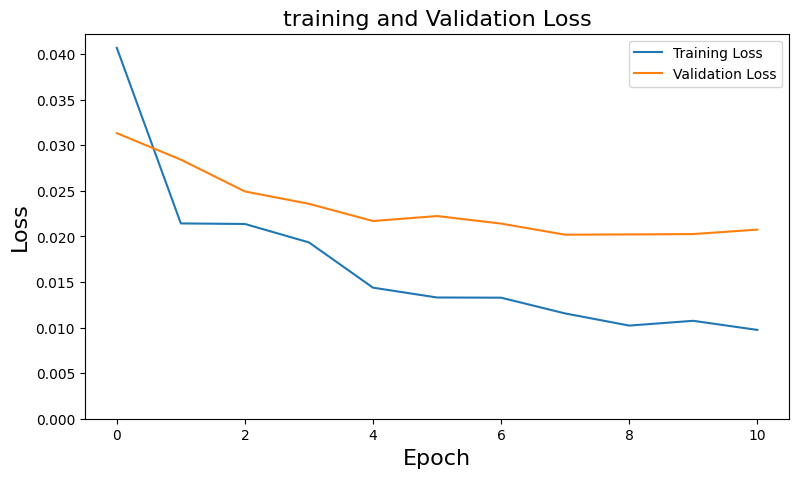

In [103]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch' ,fontsize=16)
plt.ylabel('Loss' ,fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title('training and Validation Loss',fontsize=16)
plt.show()

4)Değerlendirme

In [104]:
loss = model.evaluate(X_test,y_test,batch_size=1)
print("\nTest loss: %.1f%%" % (100.0 * loss))

47/47 [==============================] - 0s 2ms/step - loss: 0.0208

Test loss: 2.1%


In [105]:
train_predict=model.predict(X_train)

3/3 [==============================] - 0s 4ms/step


In [106]:
test_predict=model.predict(X_test)

2/2 [==============================] - 0s 5ms/step


In [107]:
train_predict=scaler_train.inverse_transform(train_predict)
test_predict=scaler_test.inverse_transform(test_predict)  #0 ile 1 arasında olan değerleri tekrar orjinal değerlerine çeviriyoruz

In [108]:
y_train=scaler_train.inverse_transform(y_train)  #orjinal verideki değerleri eski haline getirdik
y_test=scaler_test.inverse_transform(y_test)

In [109]:
#Train verisetine ait RMSE değeri
train_rmse= np.sqrt(mean_squared_error(y_train,train_predict))

In [110]:
#Test verisetine ait RMSE değeri
test_rmse= np.sqrt(mean_squared_error(y_test,test_predict))

In [111]:
print(f"Train RMSE: {train_rmse}") #burda gerçek veridenne kadar uzak tahmin yaptığımızı görüyoruz
print(f"Test RMSE: {test_rmse}")

Train RMSE: 25.406896591186523
Test RMSE: 46.241905212402344


In [112]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


In [113]:
train_prediction_df=result_df[lookback:position]

In [114]:
train_prediction_df["Predicted"] = train_predict

In [115]:
train_prediction_df.head()

,Passengers,Predicted
Month,,
1949-02-01,118.0,141.401047
1949-03-01,132.0,143.827728
1949-04-01,129.0,154.582306
1949-05-01,121.0,152.072449
1949-06-01,135.0,145.583420


In [116]:
test_prediction_df=result_df[position+lookback:]
test_prediction_df["Predicted"] = test_predict
test_prediction_df.head()

,Passengers,Predicted
Month,,
1957-02-01,301.0,342.096130
1957-03-01,356.0,336.953339
1957-04-01,348.0,375.225494
1957-05-01,355.0,368.532623
1957-06-01,422.0,374.388916
